# 10 Year Temperature compared to 2015 Temperature in Rochester, NY 

The data comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the datafile corresponds to a single observation.

The following variables are provided in the dataset:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

**Objectives of this analysis:**

1. Perform data wrangling to ensure data tidiness. 

2. Calculate record high and record low temperatures by day of the year over the period 2005-2014.

3. Produce a line graph of the record high and record low with the area between the lines shaded.

4. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.

5. Remove leap days (i.e. February 29th).

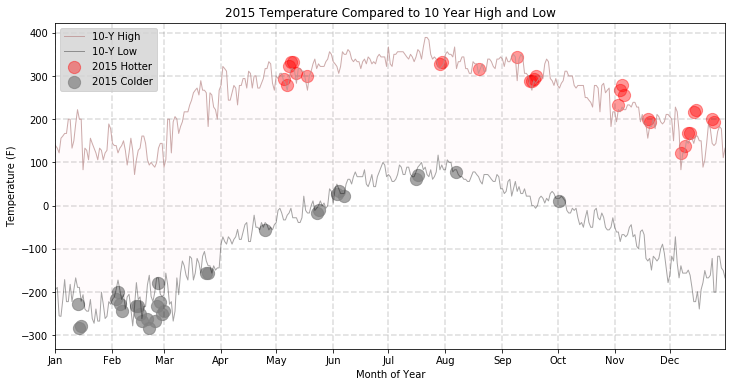

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

def plot_temp():

    # Read temperature data into a pandas dataframe
    df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/3b9925ceb5dc2fe87c621e5c35835e9d1cfcd428ef24592989b4e30b.csv')
    # Filter out lead years
    leap = df[df['Date'].str.endswith('02-29') == True]
    df = df[~df['Date'].isin(leap['Date'])]
    df = df.set_index('Date')

    year = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']
    
    # Slice dataframe into two dataframes, old_df for 10 year records, new_df for 2015 data
    old_df = df[df.index.str[:4].isin(year)]
    new_df = df[~df.index.str[:4].isin(year)]

    #######################################################################################

    # Calculate high and lows for 10 year records
    old_df.index = old_df.index.map(lambda x: x[:2] + '15'+ x[4:])

    old_df_max = old_df[old_df['Element'] == 'TMAX']
    old_df_min = old_df[old_df['Element'] == 'TMIN']

    old_df_max = old_df_max.groupby(old_df_max.index)['Data_Value'].agg({'omax': np.max})
    old_df_max.sort_values('omax')

    old_df_min = old_df_min.groupby(old_df_min.index)['Data_Value'].agg({'omin': np.min})
    old_df_min.sort_values('omin')

    plot_max = old_df_max['omax'].tolist()
    plot_min = old_df_min['omin'].tolist()

    #######################################################################################

    # Calculate daily max and mins for days in 2015
    new_df_max = new_df[new_df['Element'] == 'TMAX']
    new_df_min = new_df[new_df['Element'] == 'TMIN']

    new_df_max = new_df_max.groupby(new_df_max.index)['Data_Value'].agg({'nmax': np.max})
    new_df_max.sort_values('nmax')

    new_df_min = new_df_min.groupby(new_df_min.index)['Data_Value'].agg({'nmin': np.min})
    new_df_min.sort_values('nmin')

    # Find out whether 2015 daily high and lows break the 10 year records
    scatter_data = pd.concat([old_df_max, old_df_min, new_df_max, new_df_min], axis = 1)
    broken_max = scatter_data[scatter_data['nmax'] > scatter_data['omax']]
    broken_max.index = pd.to_datetime(broken_max.index)
    broken_min = scatter_data[scatter_data['nmin'] < scatter_data['omin']]
    broken_min.index = pd.to_datetime(broken_min.index)

    #######################################################################################

    # Plot line graph of 10 year record high and lows
    dates = pd.date_range('1/1/2015','31/12/2015', freq='D')
    plt.figure(figsize=(12, 6))
    plt.plot(dates, old_df_max['omax'].values, color = 'rosybrown', alpha = 0.75, linewidth = 1, label = '10-Y High')
    plt.plot(dates, old_df_min['omin'].values, color = 'black', alpha = 0.35, linewidth = 1, label = '10-Y Low')

    plt.gca().fill_between(dates,
                       old_df_max['omax'].values, old_df_min['omin'].values,
                       facecolor='pink',
                       alpha=0.05)
    ax = plt.gca()
    myFmt = mdates.DateFormatter('%b')
    months = mdates.MonthLocator()
    
    # Setting xaxis labels to each month in 2015
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(myFmt)

    ax.set_xlim([min(dates), max(dates)])

    axe = plt.subplot(111)

    # Overlay a scatter plot of 2015 daily high and lows that break 10 year records
    axe.scatter(broken_max.index, broken_max['nmax'].values, s = 150, c = 'red', alpha = 0.4, label = '2015 Hotter')
    axe.scatter(broken_min.index, broken_min['nmin'].values, s = 150, c = 'gray', alpha = 0.7, label = '2015 Colder')

    ax.grid(which='major', axis='both', linestyle='--', linewidth = 0.2, color = 'black')

    plt.xlabel('Month of Year')
    plt.ylabel('Temperature (F)')
    plt.title('2015 Temperature Compared to 10 Year High and Low')
    plt.legend(loc=2, frameon=True, facecolor='lightgrey')
    
    return plt.show()
plot_temp()
